In [1]:
# Import modules

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as si

import astropy.constants as con

import pymsg

# Set plot parameters

%matplotlib inline
plt.rcParams.update({'font.size': 16})

In [2]:
# Create SpecGrid object

specgrid = pymsg.SpecGrid('sg-6678.h5')

In [3]:
def synthesize_spectrum(lam, d, bruce_file, specgrid):
    
    # Initialize the flux array
    
    n_lam = len(lam)
    
    F = np.zeros(n_lam-1)
    
    # Open the BRUCE output file
    
    with si.FortranFile(bruce_file, 'r') as f:
        
        # Read header
        
        record = f.read_record('<i4', '<f4')
    
        n_vis = record[0][0]
        time = record[1][0]
        
        # Read elements and accumulate flux
    
        for i in range(n_vis):
            
            Teff, V_proj, A_proj, g, mu = f.read_reals('<f4')
            
            # Evaluate specific intenensity
            
            x = {'Teff': Teff, 'log(g)': np.log10(g)+2.}
        
            dI = specgrid.intensity(x, mu, lam*(1+V_proj/con.c.value))
        
            # Accumulate flux
        
            F += A_proj * dI * (1./d)**2
        
    # Return the time and flux
    
    return time, F

In [4]:
# Set up parameters

d = 10*con.pc.value

lam = np.linspace(6673, 6682, 101)
lam_mid = 0.5*(lam[:-1] + lam[1:])

n_time = 20

# Evaluate spectra

time = []
F = []

for i in range(n_time):
    
    bruce_file = f'elements-{i+1:03d}'
    
    result = synthesize_spectrum(lam, 10*con.pc.value, bruce_file, specgrid)

    time += [result[0]]
    F += [result[1]]

Text(0, 0.5, 'Flux (erg/cm^2/s/Angstrom)')

<Figure size 640x480 with 0 Axes>

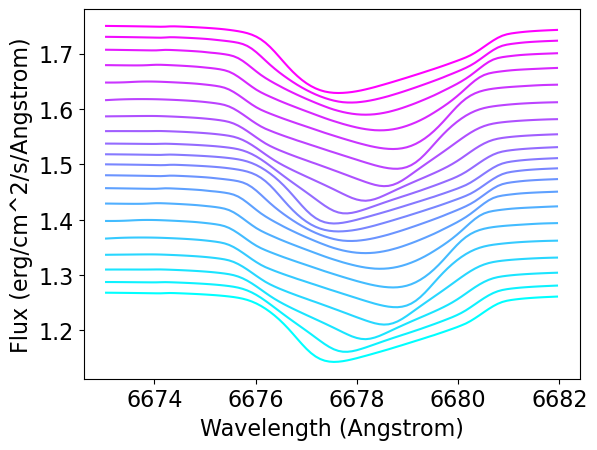

In [5]:
# Plot spectra

plt.figure()

cmap = mpl.colormaps['cool']

fig = plt.figure()

offset=0.2*(np.max(F[0]) - np.min(F[0]))

for i in range(n_time):
    
    plt.plot(lam_mid, 1E8*(F[i]+i*offset), color=cmap(i/(n_time-1)))

plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux (erg/cm^2/s/Angstrom)')